## Lab 4: Quantum Fourier Transform ##

In [1]:
import numpy as np
from numpy import pi

In [2]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg'

### 3-qubit case ###

In [3]:
# define Quantum Circuit
qc = QuantumCircuit(3)

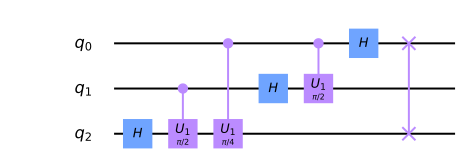

In [4]:
# apply gates

qc.h(2) # Hadamard
qc.cu1(pi/2, 1, 2) # CROT
qc.cu1(pi/4, 0, 2) # CROT
qc.h(1) # Hadamard
qc.cu1(pi/2,0,1) # CROT
qc.h(0) # Hadamard
qc.swap(0,2) # swap gate

qc.draw('mpl')

### General circuit for QFT ###

Easier to build with qubits upside down, then swap afterwards

In [5]:
def qft_rotations(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n) # apply Hadamard to most significant qubit
    for qubit in range(n):
        # small angle controlled rotation for each less significant qubit
        circuit.cu1(pi/2**(n-qubit), qubit, n)

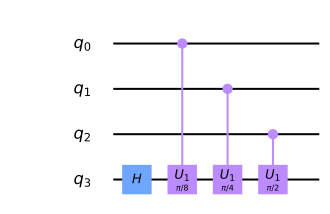

In [6]:
qc = QuantumCircuit(4)
qft_rotations(qc, 4)
qc.draw('mpl')

In [7]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

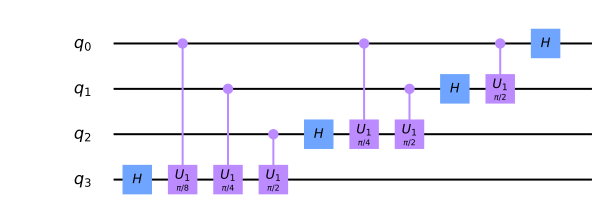

In [8]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

In [9]:
# add swaps to match definition of QFT

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

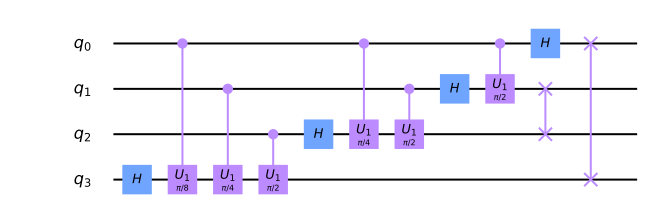

In [10]:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

In [11]:
bin(5) # 5 in binary (computational basis)

'0b101'

In [12]:
qc = QuantumCircuit(3)

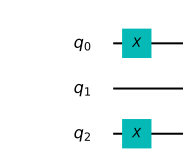

In [13]:
qc.x(0)
qc.x(2)
%config InlineBackend.figure_format = 'svg' # Makes the images fit
qc.draw('mpl')

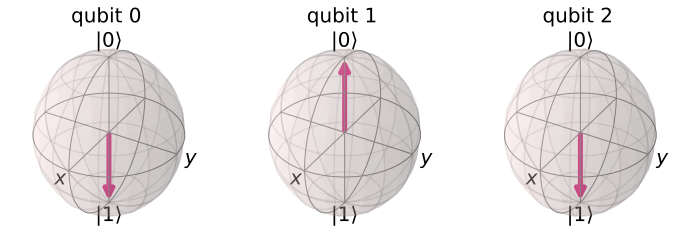

In [14]:
# qubit states on bloch sphere with statevector simulator

backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

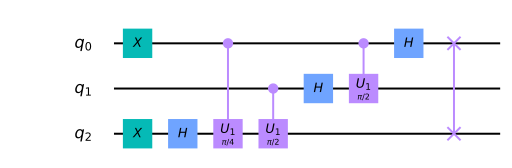

In [15]:
qft(qc,3)
qc.draw('mpl')

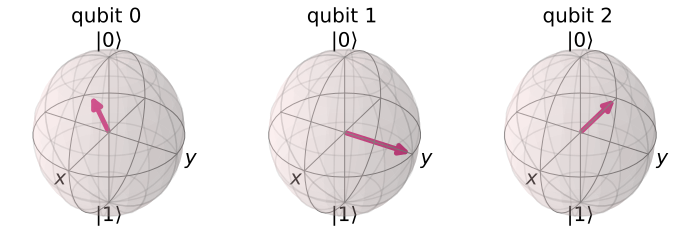

In [16]:
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

### Running QFT on a Real Quantum Device ###

In [17]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

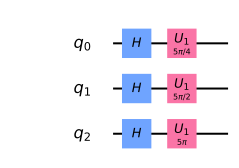

In [18]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)

qc.draw('mpl')

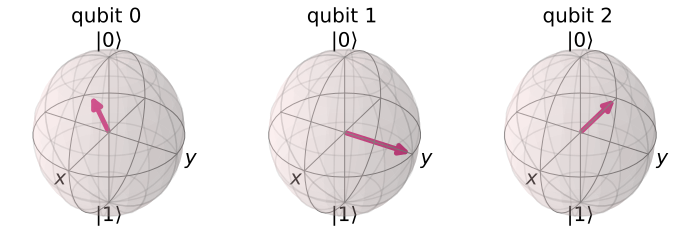

In [19]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

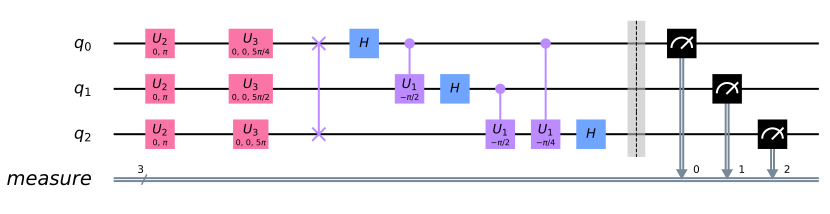

In [20]:
# apply inverse QFT
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

In [21]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_london


In [22]:
shots = 2048
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


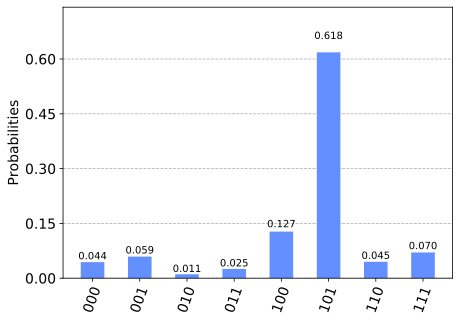

In [23]:
counts = job.result().get_counts()
plot_histogram(counts)

### Problems ###

1. The above implementation of QFT was tested by preparing the Fourier state $|\widetilde{5}\rangle$ for which $\text{QFT}^{\dagger}|\widetilde{5}\rangle = |101\rangle$. Try to find the state $|a\rangle$ such that $\text{QFT}^{\dagger}|a\rangle = |100\rangle$.

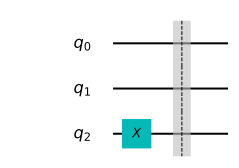

In [24]:
# 4 in binary is |100>. Encode this into qubits
# q0 = 0
# q1 = 0
# q2 = 1
qc = QuantumCircuit(3)

qc.x(2)
qc.barrier()
qc.draw('mpl')

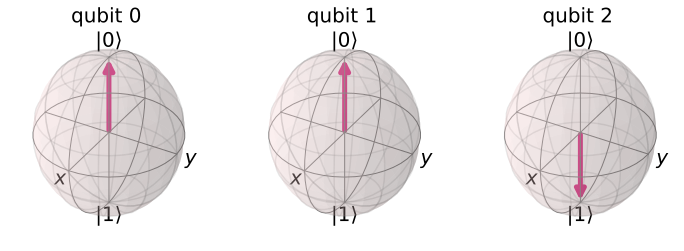

In [25]:
# check qubit's states using statevector sim
backend_sim = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend_sim).result().get_statevector()
plot_bloch_multivector(statevector)

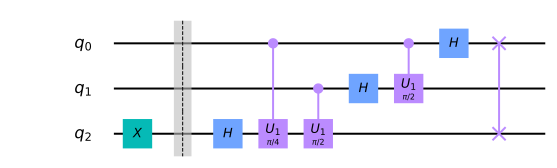

In [26]:
# use QFT
qft(qc, 3)
qc.draw('mpl')

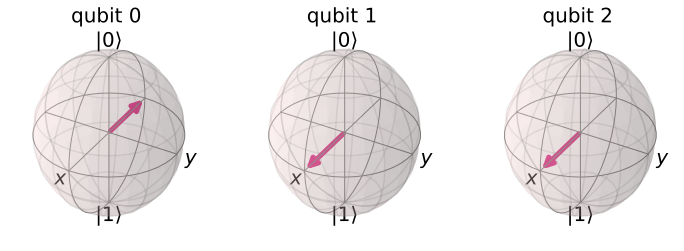

In [27]:
statevector = execute(qc, backend=backend_sim).result().get_statevector()
plot_bloch_multivector(statevector)

In [28]:
# Now to demonstrate this on real hardware

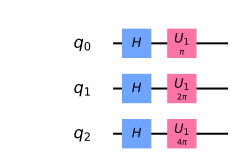

In [29]:
nqubits = 3
number = 4
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)

qc.draw('mpl')

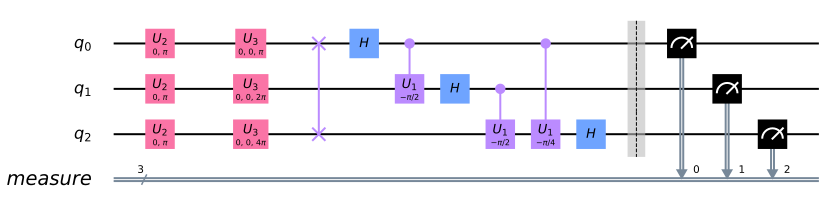

In [30]:
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

In [31]:
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


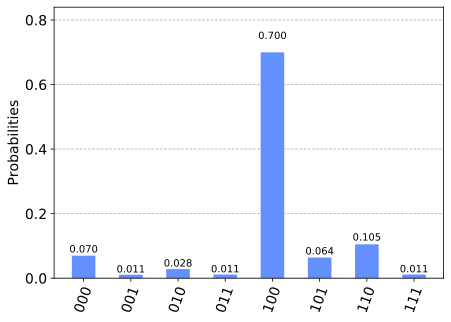

In [32]:
counts = job.result().get_counts()
plot_histogram(counts)

2. Find the state $|b\rangle$ such that $\text{QFT}^{\dagger}|b\rangle = |011\rangle$.

In [33]:
bin(3)

'0b11'

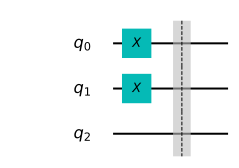

In [34]:
# 3 in binary is |011>. Encode this into qubits
# q0 = 1
# q1 = 1
# q2 = 0

qc = QuantumCircuit(3)

qc.x(0)
qc.x(1)

qc.barrier()
qc.draw('mpl')

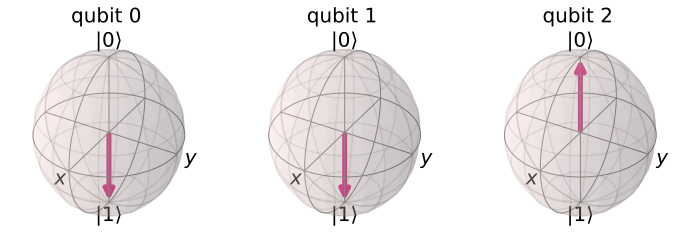

In [35]:
# check qubit's states using statevector sim
backend_sim = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend_sim).result().get_statevector()
plot_bloch_multivector(statevector)

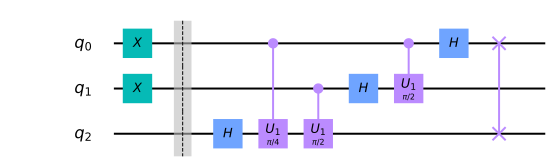

In [36]:
# use QFT
qft(qc, 3)
qc.draw('mpl')

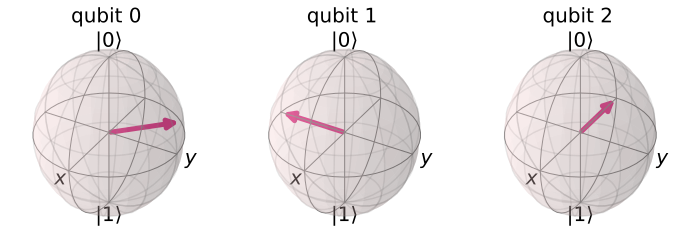

In [37]:
statevector = execute(qc, backend=backend_sim).result().get_statevector()
plot_bloch_multivector(statevector)

In [38]:
# Now to demonstrate this on real hardware

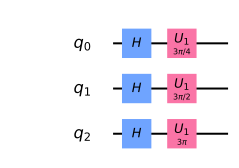

In [39]:
nqubits = 3
number = 3
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)

qc.draw('mpl')

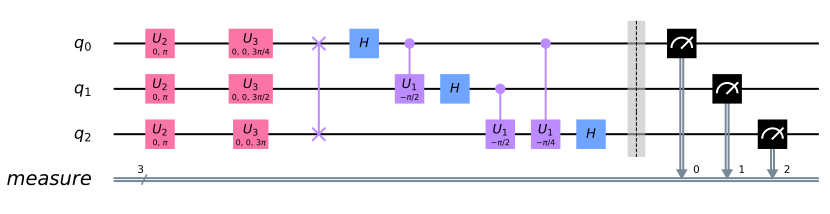

In [40]:
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

In [41]:
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


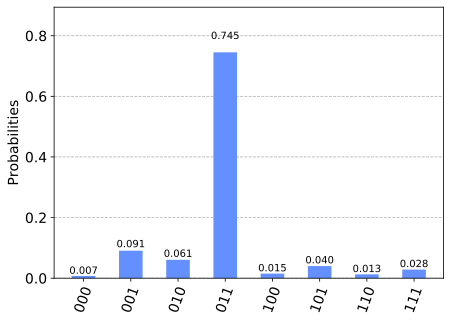

In [42]:
counts = job.result().get_counts()
plot_histogram(counts)

3. Try to write the QFT function without recursion. Use Qiskit's unitary simulator to verify your result

In [43]:
# WITHOUT RECURSION
# rotate second most significant, followed by third and so on

def qft_rotations(circuit,n):
    """use while loop instead of recursion"""
    if n == 0:
        return circuit
    while n > 0: 
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(pi/2**(n-qubit), qubit, n)  

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on first n qubits in circuit"""
    qft_rotations(circuit, n)
    circuit.barrier() # for aesthetics
    swap_registers(circuit, n)
    return circuit

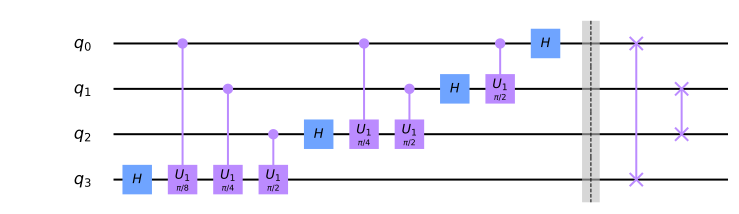

In [44]:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

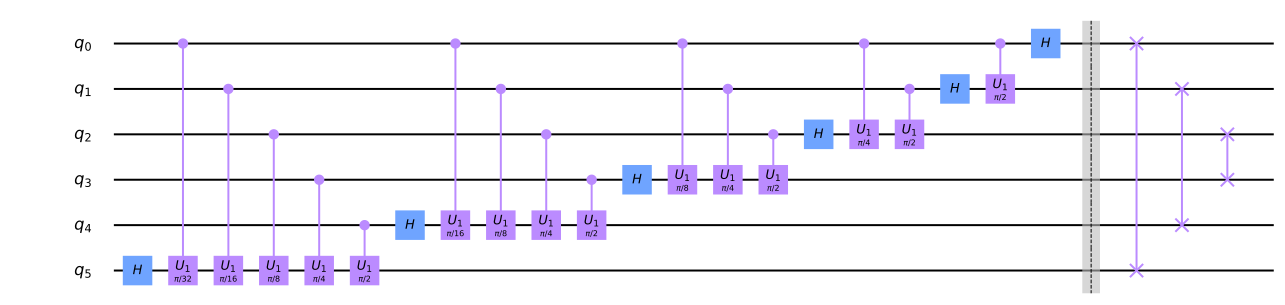

In [45]:
qc = QuantumCircuit(6)
qft(qc,6)
qc.draw('mpl')